# Load and Test Model for single video

In [1]:
# Replace this video name with other video names in the test set.
# Example: signer34_sample43, signer34_sample145, signer30_sample576
vid_name = "signer34_sample4"

## Load dependencies

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import time
from datetime import datetime
import sys
import av
import pandas as pd
import os

## Init file paths and dataframes

In [3]:
data_dir = "dataset"
test_dir = f'../../{data_dir}/test'

In [4]:
# All labels
filtered_data = "data"
test_label_df = pd.read_csv(f'../../{filtered_data}/test.csv', header=None)

# convert all into hashmap - key = u_vid_name , value = label
test_label = {f"../../{test_dir}/{k[0]}": k[1] for k in test_label_df.values.tolist()}

In [5]:
# Total label + turkish to english translation
total_label = pd.read_csv(f'../../{filtered_data}/filtered_ClassId.csv')
u_len_label = len(total_label['ClassId'].unique())
print("total unique label:", u_len_label)

total unique label: 10


In [6]:
class_id_to_label = {k[0]: k[2] for k in total_label.values.tolist()}

In [7]:
print(class_id_to_label)

{0: 'champion', 1: 'glass', 2: 'wrong', 3: 'bad', 4: 'married', 5: 'potato', 6: 'congratulations', 7: 'child', 8: 'inform', 9: 'father'}


## Load and process video

In [8]:
def extract_frames(vid_path, frames_cap, transforms=None):
    """Extract and transform video frames

    Parameters:
    vid_path (str): path to video file
    frames_cap (int): number of frames to extract, evenly spaced
    transforms (torchvision.transforms, optional): transformations to apply to frame

    Returns:
    list of numpy.array: vid_arr

    """
    vid_arr = []
    with av.open(vid_path) as container:
        stream = container.streams.video[0]
        n_frames = stream.frames
        remainder = n_frames % frames_cap
        interval = n_frames // frames_cap
        take_frame_idx = 0
        for frame_no, frame in enumerate(container.decode(stream)):
            if frame_no == take_frame_idx:
                img = frame.to_image()
                if transforms:
                    img = transforms(img)
                vid_arr.append(np.array(img))
                if remainder > 0:
                    take_frame_idx += 1
                    remainder -= 1
                take_frame_idx += interval
    if len(vid_arr) < frames_cap:
        raise ValueError(f"video with path '{vid_path}' is too short, please make sure that video has >={frames_cap} frames")
    return vid_arr

In [9]:
transforms_compose = transforms.Compose([transforms.Resize(256), 
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5], std=[0.5])])
vid_color_path = f"{test_dir}/{vid_name}_color.mp4"
rgb_arr = extract_frames(vid_color_path, 30, transforms=transforms_compose)
vid_arr = np.array(rgb_arr)
vid_arr = vid_arr / 255
vid_arr = torch.from_numpy(vid_arr).float()
vid_arr = vid_arr.unsqueeze(0)
# batch_size, timesteps, C, H, W = x.size()

In [10]:
print(vid_arr.size())

torch.Size([1, 30, 3, 256, 256])


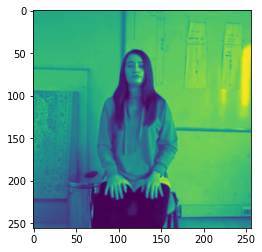

In [11]:
# display single frame
img_np_arr = vid_arr[0][0][0].numpy()
plt.imshow(img_np_arr)
plt.show()

## Load model

In [12]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [13]:
from models import CNN_LSTM
model = CNN_LSTM(10, 
                 latent_size=512, 
                 n_cnn_layers=6, 
                 n_rnn_layers=1, 
                 n_rnn_hidden_dim=512, 
                 cnn_bn=True, 
                 bidirectional=True, 
                 dropout_rate=0.8,
                 device="cpu",
                 attention=True)
checkpoint = torch.load("../../models/8-checkpoint.pt", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CNN_LSTM(
  (encoder): CNN_Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layers): Sequential(
      (0): ConvBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (a_fn): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(128, 

## Test model

In [ ]:
transforms_compose = transforms.Compose([transforms.Resize(256), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5], std=[0.5])])
test_dir = f'../../{data_dir}/test'
def load_and_test_image(vid_name):
    vid_color_path = f"{test_dir}/{vid_name}_color.mp4"
    rgb_arr = extract_frames(vid_color_path, 30, transforms=transforms_compose)
    vid_arr = np.array(rgb_arr)
    vid_arr = vid_arr/255
    vid_arr = torch.from_numpy(vid_arr).float()
    vid_arr = vid_arr.unsqueeze(0)
    predict_id = model.forward(vid_arr)
    predict_id = torch.max(predict_id, 1)[1].item()
    real_id = test_label[f"../../{test_dir}/{vid_name}"]
    return predict_id, class_id_to_label[predict_id], real_id, class_id_to_label[real_id]

In [ ]:
predict_id, predict_label, real_id, real_label = load_and_test_image(vid_name)

In [14]:
print(f"Ground truth: {real_label}")
print(f"Predicted label: {predict_label}")

The class Id if the output is: 0
